# 5. Grain phase function

## Overview

This tutorial showcases a more practical application and is a great introduction to write efficient integrator-like rendering code with the Mitsuba library.

In volumetric rendering, we talk about a *phase function* to discribe the angular distribution of light scattering when interacting with a particle in the medium. Have you ever wondered how a participating medium would look like if every particle had the shape of a bunny, or was made of frosty glass? ❄️🐰 For this you would need to know the phase function of such a medium, and this is what we are going to compute in this tutorial.

The following code is inspired from this great [paper](https://cs.dartmouth.edu/wjarosz/publications/meng15granular.html) where the authors manage to efficiently render granular materials, like sand, snow or sugar.

At a very high-level, here are the key stages of the algorithm we are going to use in this tutorial:

- Represent a single particle with a shape and a BSDF
- Generate rays coming from random directions around the particle object
- Compute bounces of the light path inside the particle until they escape
- Once escaped, record the out-going direction in the local frame of the original direction into an histogram

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Use a sampler to generate random numbers</li>
  <li>Write a custom integrator-like script</li>
  <li>Use enoki symbolic loops and vectorized virtual function call</li>
</ul>
    
</div>


### Step 1 - setup

Given the fact that phase functions can be wavelength-dependent, it only makes sense to perform our computations for a single wavelength at a time.  Luckily for us, as described in the [first tutorial](...), one key feature our retargetable renderer is the ability to choose the type used to represent colors in the simulation. Hence this is the perfect occasion to use the `mono` variant of our system, with which colors will be represented as a 1D array `Color1f`.

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('/home/speierers/projects/mitsuba2-symbolic/build/python')

In [2]:
import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_mono')

### Step 2 - initialize the scene

To keep this tutorial simple, we are only going to compute the phase function of a dielectric sphere. Although it goes without saying that only minor changes would be necessary to allow the use of other shapes and materials in this script.

On top of various mesh loaders (e.g. `ply`, `obj`, ...), Mitsuba supports several analytical shapes (e.g. `Sphere`, `Rectangle`, ...), that can be very handy when writing prototype applications. Also, note that even for a single object, ray-tracing operations in Mitsuba require the construction of a scene as it is responsible for the proper initialization of the ray-tracing backends (e.g. Embree / OptiX). 

Once again, we are going to use the `load_dict` routine to instanciate a scene containing a sphere and a dielectric BSDF.

In [3]:
from mitsuba.core.xml import load_dict

scene = load_dict({
    'type' : 'scene',
    'grain' : {
        'type' : 'sphere',
    }
})

bsdf = load_dict({
    'type' : 'dielectric',
    'int_ior' : 'water', # can also use float values
    'ext_ior' : 'air',   
})

2021-04-23 17:08:06 WARN main [Scene] No sensors found! Instantiating a perspective camera..

2021-04-23 17:08:06 WARN main [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgba).

2021-04-23 17:08:06 WARN main [Scene] No integrator found! Instantiating a path tracer..

2021-04-23 17:08:06 INFO main [Scene] Building scene in OptiX ..

2021-04-23 17:08:06 INFO main [Scene] OptiX ready. (took 44ms)

Performing Monte-Carlo integrator requires the ability to generate random number. Mitsuba as all good rendering framework comes along a set of `Sampler` classes that can be used to perform such task. For simplicity in this application we are going to use the most basic sampler, `independent`, which we can instanciate with the `load_dict` routine.

In order to write vectorized code, we need to choose a *wavefront* size, corresponding to the amount of light path we are going to compute simultaneously. The `sampler` instance needs to be aware of the wavefront size so to produce random arrays of the right size.

In [4]:
sampler = load_dict({'type' : 'independent'})

wavefront_size = int(1e7)
sampler.seed(0, wavefront_size)

### Step 3 - perform intra-grain transport

It wouldn't make sense to use a conventional sensor for the ray generation, therefore are are going to write custom code for it.

In [5]:
from mitsuba.core.warp import square_to_uniform_sphere
from mitsuba.core import Float, UInt32, Mask, Spectrum, Vector3f, Ray3f, Frame3f
from mitsuba.render import BSDFContext

# Parameters
wavelength = Spectrum(600.0)
max_bounces = 12
histogram_size = 512

# Generate primary rays coming from all directions towards the center of the object
frame = Frame3f(square_to_uniform_sphere(sampler.next_2d()))
offset = 2.0 * (sampler.next_2d() - 0.5)
o = frame.to_world(Vector3f(offset.x, offset.y, -2))
rays = Ray3f(o, frame.n, time=0.0, wavelengths=wavelength)

# Other loop variables
entered = False
escaped = False
active = True
throughput = Spectrum(1.0)

# Ray tracing loop
for bounce in range(max_bounces):
    # Find ray intersection with the object
    si = scene.ray_intersect(rays, active)
    active &= si.is_valid()    
    escaped |= entered & ~si.is_valid()
    entered |= si.is_valid()
    
    # Sample new direction and update throughput and rays for next bounce    
    ctx = BSDFContext()
    bs, bsdf_val = bsdf.sample(ctx, si, sampler.next_1d(active), sampler.next_2d(active), active)
    throughput[active] = bsdf_val * throughput
    rays[active] = si.spawn_ray(si.to_world(bs.wo))
    ek.eval(rays, throughput, active, escaped, entered)

# Convert escaping directions into histogram bin indices
cos_theta = Frame3f.cos_theta(frame.to_local(rays.d))
theta = ek.acos(cos_theta)
theta_jacobian = 1 / ek.sqrt(1 - cos_theta**2)
theta_idx = UInt32(theta / ek.Pi * histogram_size)

# Scatter theta values into the histogram
histogram = ek.zero(Float, histogram_size)
ek.scatter_reduce(ek.ReduceOp.Add, histogram, throughput * theta_jacobian, theta_idx, escaped)

# Execute the kernel by evaluating the histogram
ek.eval(histogram)

### Step 4 - plot the histogram

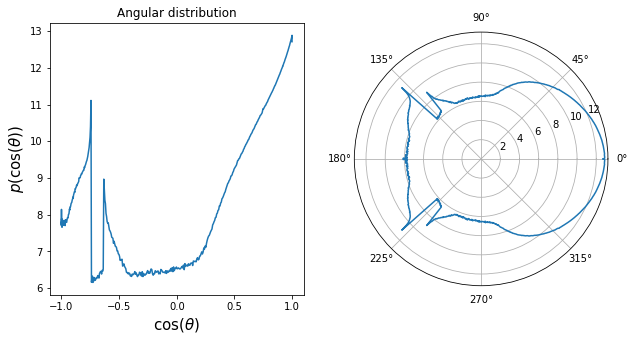

In [6]:
import numpy as np 
from matplotlib import pyplot as plt

x = ek.linspace(Float, 0, ek.Pi, len(histogram), endpoint=True)
histogram2 = ek.log(histogram)

fig = plt.figure(figsize = (10, 5))

ax = fig.add_subplot(121, title='Angular distribution') 
ax.plot(ek.cos(x), histogram2, color='C0')
ax.set_xlabel(r'$\cos(\theta)$', size=15)
ax.set_ylabel(r'$p(\cos(\theta))$', size=15)

ax = fig.add_subplot(122, polar=True, title='polar plot') 
ax.plot(x,  histogram2, color='C0')
ax.plot(-x, histogram2, color='C0', label='test');

### *Reference API*

- [<code>mitsuba.core.xml.load_dict</code>](...)
- [<code>mitsuba.core.warp.square_to_uniform_sphere</code>](...)
- [<code>mitsuba.core.Ray3f</code>](...)